In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm



import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

In [2]:
nside = 64

sky = get_sky(nside, 'd1s1')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)

In [3]:
pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


# Creazione patch

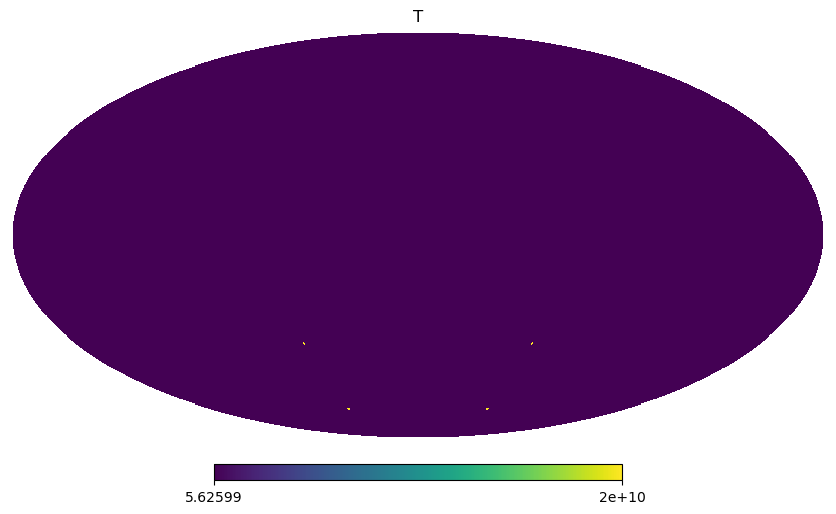

In [6]:
# VISUALIZZO DOVE DOVREBBE STARE LA PATCH PER AVERE UN IDEA
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40

theta1 = np.deg2rad(RA1)
theta2 = np.deg2rad(RA2)

phi1   = 0.5 * np.pi - np.deg2rad(dec1) 
phi2   = 0.5 * np.pi - np.deg2rad(dec2)

# trasformo la lat e lon in indici
index1 = hp.ang2pix(nside,phi1, theta1)
index2 = hp.ang2pix(nside, phi2, theta1)
index3 = hp.ang2pix(nside, phi2, theta2)
index4 = hp.ang2pix(nside,phi1, theta2) 


freq_maps[0, 0, index1] = 2e10
freq_maps[0, 0, index2] = 2e10
freq_maps[0, 0, index3] = 2e10
freq_maps[0, 0, index4] = 2e10

#freq_maps[0, 0, 21010] = 2e10
#freq_maps[0, 0, index2: index1] = 5

hp.mollview(freq_maps[0,0, :], title='T')

In [7]:
# ricreo la mappa per togliere i 4 punti
freq_maps = get_observation(instrument, sky)

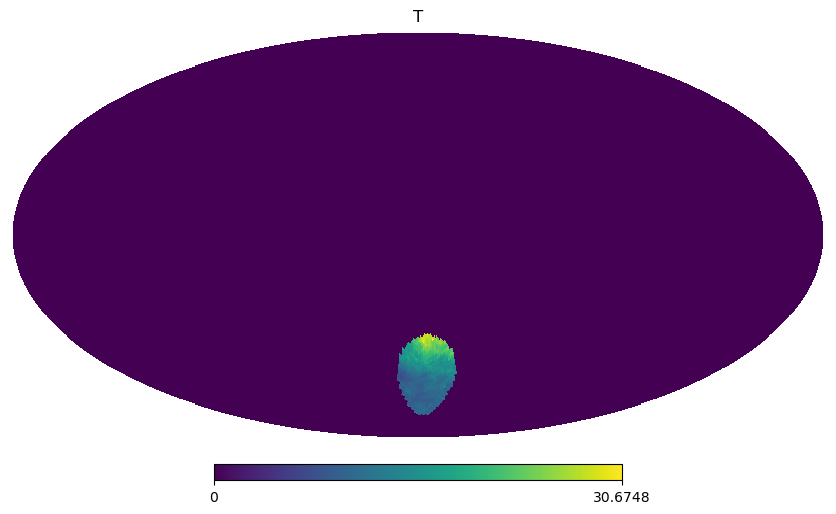

In [8]:
# create 3% circular sky mask
RA  = 2*np.pi-5.*np.pi/180
DEC = np.pi/2+55.*np.pi/180

radius = 18*np.pi/180

mask_circular = np.zeros(12*nside**2)

for ipix in range(12*nside**2):
    theta, phi = hp.pix2ang(nside, ipix)
    if (((phi - RA)**2 + (theta - DEC)**2 <= radius**2)):
        mask_circular[ipix] = 1.0
    if (((phi - RA+2*np.pi)**2 + (theta - DEC)**2 <= radius**2)):
        mask_circular[ipix] = 1.0

# applying mask to observed frequency maps
freq_maps[...,mask_circular==0] = 0.0
hp.mollview(freq_maps[0, 0, :], title='T')

In [9]:
# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


np.shape(mappa40)

(3, 49152)

In [10]:
I_map40 = mappa40[0,:]
Q_map40 = mappa40[1,:]
U_map40 = mappa40[2,:]

I_map60 = mappa60[0,:]
Q_map60 = mappa60[1,:]
U_map60 = mappa60[2,:]

I_map78 = mappa78[0,:]
Q_map78 = mappa78[1,:]
U_map78 = mappa78[2,:]

I_map100 = mappa100[0,:]
Q_map100 = mappa100[1,:]
U_map100 = mappa100[2,:]

I_map140 = mappa140[0,:]
Q_map140 = mappa140[1,:]
U_map140 = mappa140[2,:]

I_map195 = mappa195[0,:]
Q_map195 = mappa195[1,:]
U_map195 = mappa195[2,:]

I_map280 = mappa280[0,:]
Q_map280 = mappa280[1,:]
U_map280 = mappa280[2,:]

I_map402 = mappa402[0,:]
Q_map402 = mappa402[1,:]
U_map402 = mappa402[2,:]

np.shape(I_map40)

(49152,)

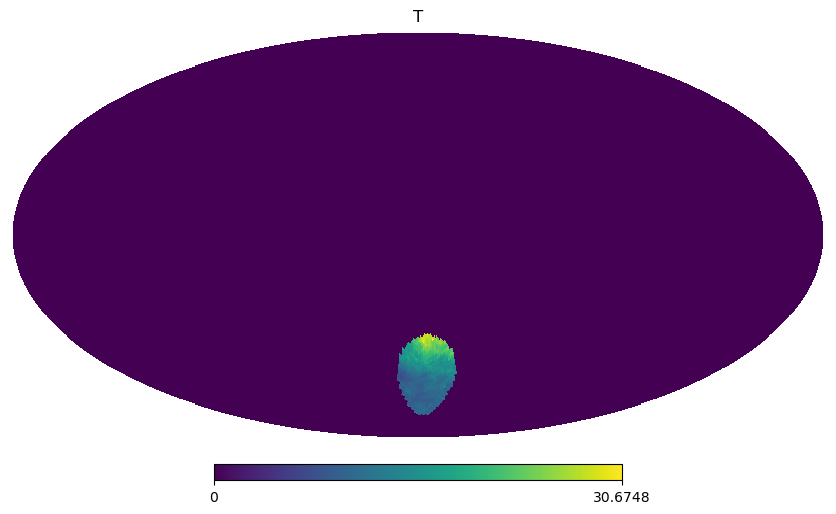

In [11]:
hp.mollview(I_map40, title='T')

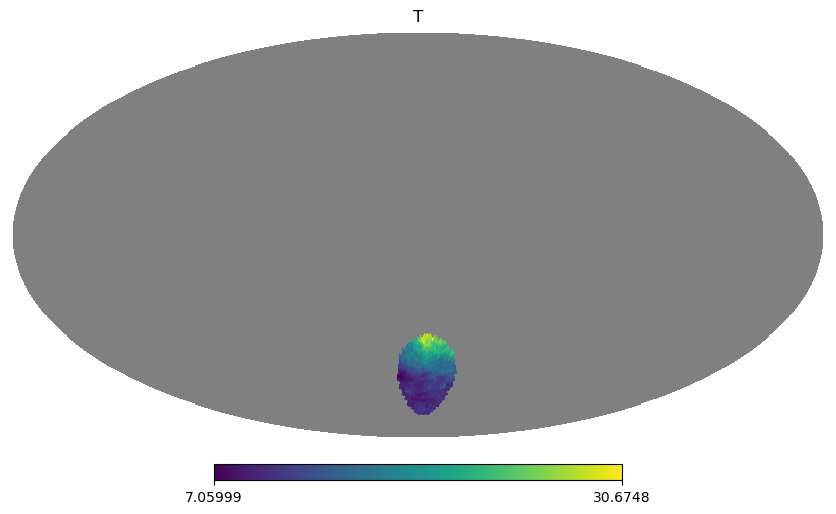

In [12]:
# creo una copia di una e uso hp.UNSEEN per la visualizzazione

I_map2 = np.array(I_map40)

for i in range(len(I_map2)):
    if I_map2[i] == 0:
        I_map2[i] = hp.UNSEEN
        
hp.mollview(I_map2, title='T')

In [13]:
x = np.sqrt(len(I_map40)*2)+1
int(x)

314

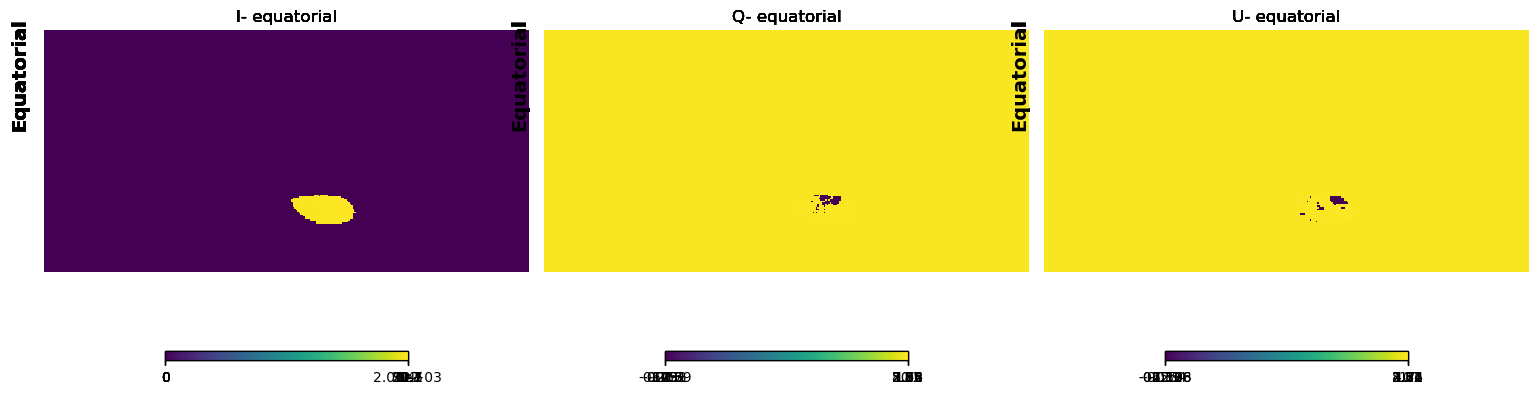

In [14]:
plt.figure(figsize=(15, 10))

I2d_40   = hp.cartview(I_map40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_40   = hp.cartview(Q_map40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_40   = hp.cartview(U_map40, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

I2d_60   = hp.cartview(I_map60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_60   = hp.cartview(Q_map60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_60   = hp.cartview(U_map60, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

I2d_78   = hp.cartview(I_map78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_78   = hp.cartview(Q_map78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_78   = hp.cartview(U_map78, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

I2d_100  = hp.cartview(I_map100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_100  = hp.cartview(Q_map100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_100  = hp.cartview(U_map100, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

I2d_140   = hp.cartview(I_map140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_140   = hp.cartview(Q_map140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_140   = hp.cartview(U_map140, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

I2d_195   = hp.cartview(I_map195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_195   = hp.cartview(Q_map195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_195   = hp.cartview(U_map195, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


I2d_280   = hp.cartview(I_map280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_280   = hp.cartview(Q_map280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_280   = hp.cartview(U_map280, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))


I2d_402   = hp.cartview(I_map402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I- equatorial", sub=(1, 3, 1))
Q2d_402   = hp.cartview(Q_map402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q- equatorial", sub=(1, 3, 2))
U2d_402   = hp.cartview(U_map402, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U- equatorial", sub=(1, 3, 3))

In [15]:
# DIMENSIONI MAPPE

In [16]:
Ny, Nx = np.shape(I2d_40) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  

314 157


# Beam

ellipticity =  -0.2


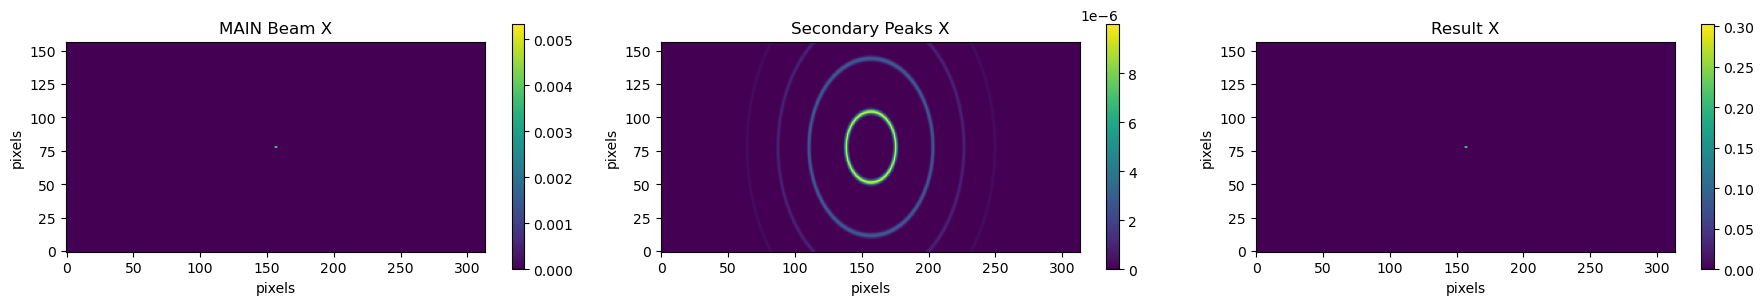

In [17]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

#X = np.outer(onesy, indsx)
#Y = np.outer(indsy, onesx)
X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 40  #degrees
FWHM_y = 60  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([80000, 200000, 300000, 400000]) #angular distance of the peaks
r = 100 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

# PLOT

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
titles = ['MAIN Beam X', 'Secondary Peaks X', 'Result X']
data_list = [beam_gauss_x, sec_rings_x, beam_x]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    cbar = plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

beam max: 4.342923104481638e-05 beam min: 4.0611233921280565


0

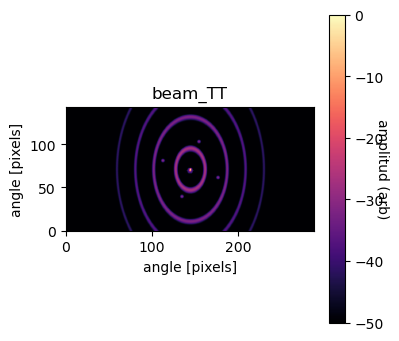

In [18]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":105.5,"R":2000.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


######################################################################################################################################
beam_to_plot = beam_TT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width, Y_width,  "beam_TT", 'angle [pixels]')

In [19]:
# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf_40 = convolve_map_with_beam(Q2d_40, perf_beam)
U_conv_perf_40 = convolve_map_with_beam(U2d_40, perf_beam)

Q_conv_perf_60 = convolve_map_with_beam(Q2d_60, perf_beam)
U_conv_perf_60 = convolve_map_with_beam(U2d_60, perf_beam)

Q_conv_perf_78 = convolve_map_with_beam(Q2d_78, perf_beam)
U_conv_perf_78 = convolve_map_with_beam(U2d_78, perf_beam)

Q_conv_perf_100 = convolve_map_with_beam(Q2d_100, perf_beam)
U_conv_perf_100 = convolve_map_with_beam(U2d_100, perf_beam)

Q_conv_perf_140 = convolve_map_with_beam(Q2d_140, perf_beam)
U_conv_perf_140 = convolve_map_with_beam(U2d_140, perf_beam)

Q_conv_perf_195 = convolve_map_with_beam(Q2d_195, perf_beam)
U_conv_perf_195 = convolve_map_with_beam(U2d_195, perf_beam)

Q_conv_perf_280 = convolve_map_with_beam(Q2d_280, perf_beam)
U_conv_perf_280 = convolve_map_with_beam(U2d_280, perf_beam)

Q_conv_perf_402 = convolve_map_with_beam(Q2d_402, perf_beam)
U_conv_perf_402 = convolve_map_with_beam(U2d_402, perf_beam)



# convolution with real beam
I_conv_real_40 = convolve_map_with_beam(I2d_40, beam_TT)
Q_conv_real_40 = convolve_map_with_beam(Q2d_40, beam_QQ)
U_conv_real_40 = convolve_map_with_beam(U2d_40, beam_UU)

I_conv_real_60 = convolve_map_with_beam(I2d_60, beam_TT)
Q_conv_real_60 = convolve_map_with_beam(Q2d_60, beam_QQ)
U_conv_real_60 = convolve_map_with_beam(U2d_60, beam_UU)

I_conv_real_78 = convolve_map_with_beam(I2d_78, beam_TT)
Q_conv_real_78 = convolve_map_with_beam(Q2d_78, beam_QQ)
U_conv_real_78 = convolve_map_with_beam(U2d_78, beam_UU)

I_conv_real_100 = convolve_map_with_beam(I2d_100, beam_TT)
Q_conv_real_100 = convolve_map_with_beam(Q2d_100, beam_QQ)
U_conv_real_100 = convolve_map_with_beam(U2d_100, beam_UU)

I_conv_real_140 = convolve_map_with_beam(I2d_140, beam_TT)
Q_conv_real_140 = convolve_map_with_beam(Q2d_140, beam_QQ)
U_conv_real_140 = convolve_map_with_beam(U2d_140, beam_UU)

I_conv_real_195 = convolve_map_with_beam(I2d_195, beam_TT)
Q_conv_real_195 = convolve_map_with_beam(Q2d_195, beam_QQ)
U_conv_real_195 = convolve_map_with_beam(U2d_195, beam_UU)

I_conv_real_280 = convolve_map_with_beam(I2d_280, beam_TT)
Q_conv_real_280 = convolve_map_with_beam(Q2d_280, beam_QQ)
U_conv_real_280 = convolve_map_with_beam(U2d_280, beam_UU)

I_conv_real_402 = convolve_map_with_beam(I2d_402, beam_TT)
Q_conv_real_402 = convolve_map_with_beam(Q2d_402, beam_QQ)
U_conv_real_402 = convolve_map_with_beam(U2d_402, beam_UU)

# Pol angle

In [20]:
std_deviation_degree = 1
std_deviation_rad    = std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.017453292519943295


In [21]:

def cosine_window_r(Nx, Ny, x_range=None, y_range=None):
    "Generates a cosine window for apodizing within specified ranges to avoid edge effects in the 2D FFT"
    # Default ranges
    if x_range is None:
        x_range = [-np.pi / 2, np.pi / 2]
    if y_range is None:
        y_range = [-np.pi / 2, np.pi / 2]
    
    # Make a 2D coordinate system within specified ranges
    x_vals = np.linspace(x_range[0], x_range[1], Nx)
    y_vals = np.linspace(y_range[0], y_range[1], Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Make a window map
    window_map = np.cos(X) * np.cos(Y)

    # Return the window map
    return window_map
'''

    
def cosine_window_r(Nx, Ny, pix_size):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system

    Nx = int(Nx)
    Ny = int(Ny)

    onesx = np.ones(Nx)
    onesy = np.ones(Ny)

    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)

    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)

'''

'\n\n    \ndef cosine_window_r(Nx, Ny, pix_size):\n    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" \n    # make a 2d coordinate system\n\n    Nx = int(Nx)\n    Ny = int(Ny)\n\n    onesx = np.ones(Nx)\n    onesy = np.ones(Ny)\n\n    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size\n    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size\n\n    X = np.outer(onesy, indsx)\n    Y = np.outer(indsy, onesx)\n\n    # make a window map\n    window_map = np.cos(X) * np.cos(Y)\n   \n    # return the window map\n    return(window_map)\n\n'

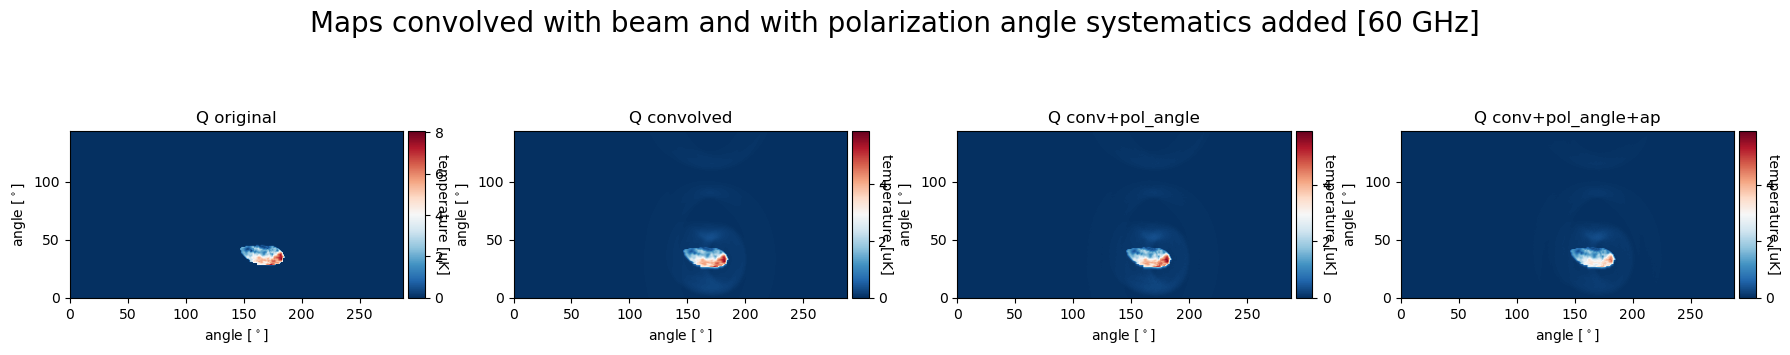

In [22]:
# POLARIZATION ANGLE
Q_polangle_40, U_polangle_40   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad)

Q_polangle_60, U_polangle_60   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad)
Q_polangle_78, U_polangle_78   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad)
Q_polangle_100, U_polangle_100 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad)
Q_polangle_140, U_polangle_140 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad)
Q_polangle_195, U_polangle_195 = polangle_map(Q_conv_real_195, U_conv_real_195, gauss_center, std_deviation_rad)
Q_polangle_280, U_polangle_280 = polangle_map(Q_conv_real_280, U_conv_real_280, gauss_center, std_deviation_rad)
Q_polangle_402, U_polangle_402 = polangle_map(Q_conv_real_402, U_conv_real_402, gauss_center, std_deviation_rad)

########################################################################################################

# APODIZATION
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /3, np.pi /3], y_range=[-np.pi /3, np.pi /3]))

Q_ap40 = window * Q_polangle_40
U_ap40 = window * U_polangle_40
I_ap40 = window * I_conv_real_40

Q_ap60 = window * Q_polangle_60
U_ap60 = window * U_polangle_60
I_ap60 = window * I_conv_real_60

Q_ap78 = window * Q_polangle_78
U_ap78 = window * U_polangle_78
I_ap78 = window * I_conv_real_78

Q_ap100 = window * Q_polangle_100
U_ap100 = window * U_polangle_100
I_ap100 = window * I_conv_real_100

Q_ap140 = window * Q_polangle_140
U_ap140 = window * U_polangle_140
I_ap140 = window * I_conv_real_140

Q_ap195 = window * Q_polangle_195
U_ap195 = window * U_polangle_195
I_ap195 = window * I_conv_real_195

Q_ap280 = window * Q_polangle_280
U_ap280 = window * U_polangle_280
I_ap280 = window * I_conv_real_280

Q_ap402 = window * Q_polangle_402
U_ap402 = window * U_polangle_402
I_ap402 = window * I_conv_real_402

########################################################################################################

# plot
Map_to_Plot = [Q2d_40, Q_conv_real_40, Q_polangle_40, Q_ap40]
title = ["Q original","Q convolved","Q conv+pol_angle", "Q conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[2])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[2])]

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolved with beam and with polarization angle systematics added [60 GHz]', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


# Component Separation

In [23]:
# Trasformo in 1D
I_flat40 = I_ap40.flatten()
Q_flat40 = Q_ap40.flatten()
U_flat40 = U_ap40.flatten()

I_flat60 = I_ap60.flatten()
Q_flat60 = Q_ap60.flatten()
U_flat60 = U_ap60.flatten()

I_flat78 = I_ap78.flatten()
Q_flat78 = Q_ap78.flatten()
U_flat78 = U_ap78.flatten()

I_flat100 = I_ap100.flatten()
Q_flat100 = Q_ap100.flatten()
U_flat100 = U_ap100.flatten()

I_flat140 = I_ap140.flatten()
Q_flat140 = Q_ap140.flatten()
U_flat140 = U_ap140.flatten()

I_flat195 = I_ap195.flatten()
Q_flat195 = Q_ap195.flatten()
U_flat195 = U_ap195.flatten()

I_flat280 = I_ap280.flatten()
Q_flat280 = Q_ap280.flatten()
U_flat280 = U_ap280.flatten()

I_flat402 = I_ap402.flatten()
Q_flat402 = Q_ap402.flatten()
U_flat402 = U_ap402.flatten()

freq40 = np.stack([I_flat40, Q_flat40, U_flat40])
freq60 = np.stack([I_flat60, Q_flat60, U_flat60])
freq78 = np.stack([I_flat78, Q_flat78, U_flat78])
freq100 = np.stack([I_flat100, Q_flat100, U_flat100])
freq140 = np.stack([I_flat140, Q_flat140, U_flat140])
freq195 = np.stack([I_flat195, Q_flat195, U_flat195])
freq280 = np.stack([I_flat280, Q_flat280, U_flat280])
freq402 = np.stack([I_flat402, Q_flat402, U_flat402])


full_array = np.array([freq40, freq60, freq78, freq100, freq140, freq195, freq280, freq402])
np.shape(full_array)

(8, 3, 49298)

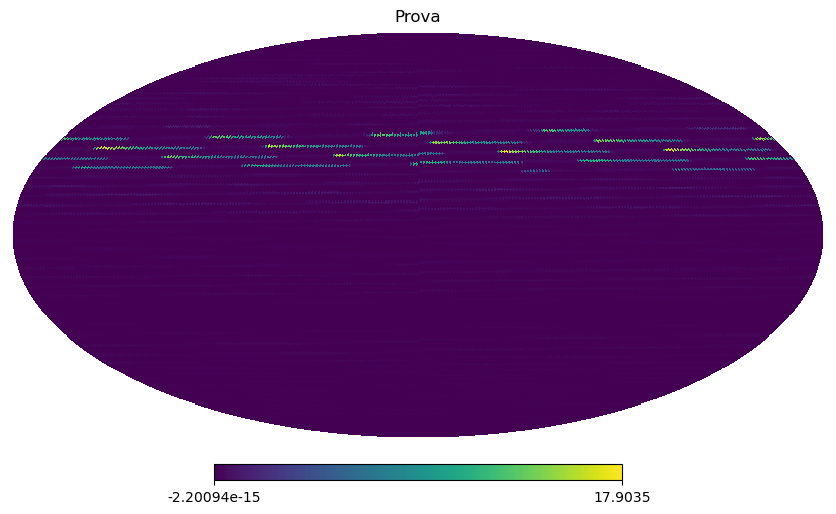

In [24]:
hp.mollview(I_flat40[:49152], title='Prova')

### Non funziona il flatten, non ricrea bene la mappa in healpy

In [25]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch

freq

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
10,195.0,5.85,4.14,28.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
12,280.0,13.80,9.76,22.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
14,402.0,47.45,33.55,17.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


In [26]:
components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result = basic_comp_sep(components, freq, full_array)

print(result.params)
print(result.x)

cmb_I  = result.s[0,0, :49152]
cmb_Q  = result.s[0,1, :49152]
cmb_U  = result.s[0,2, :49152]

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.4285182  29.86210724 -2.81962516]


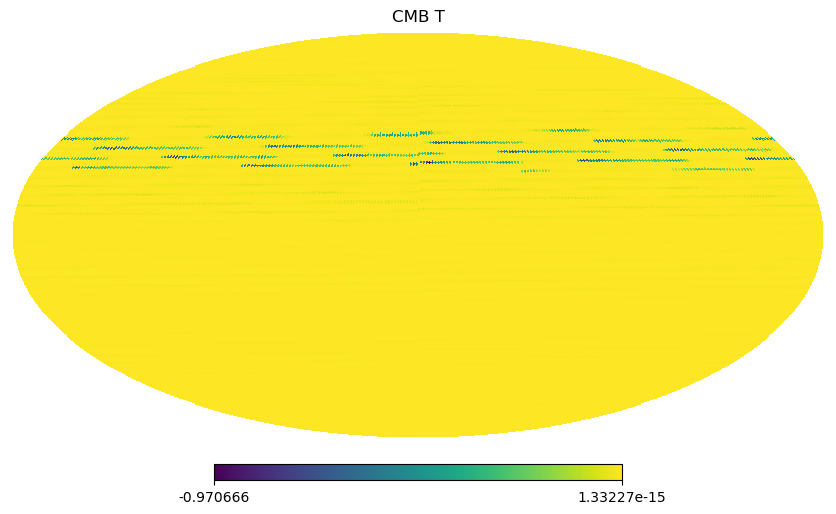

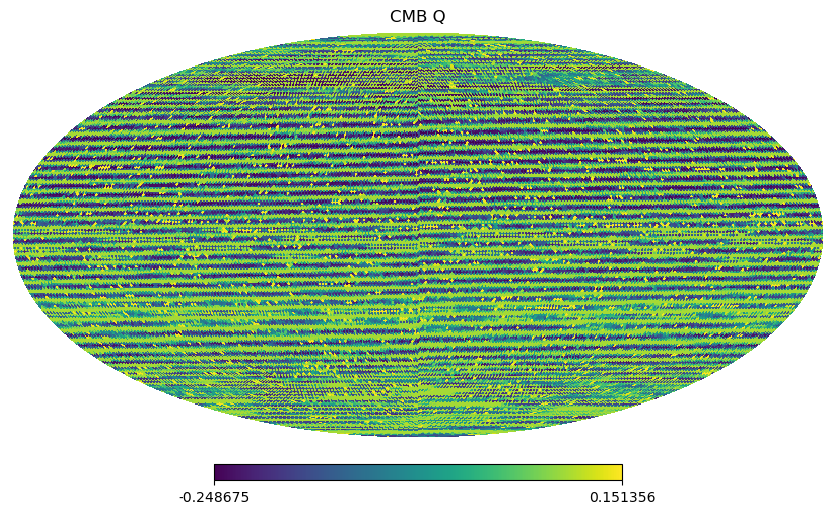

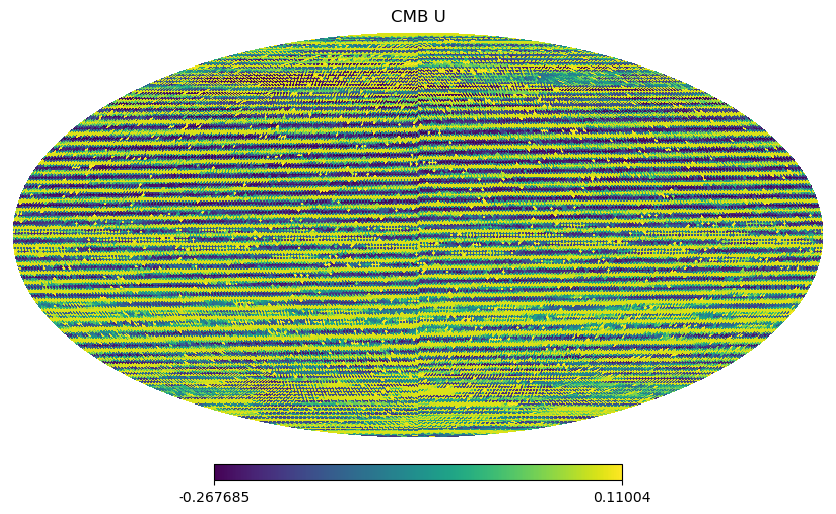

In [27]:
hp.mollview(cmb_I, title='CMB T')
hp.mollview(cmb_Q, title='CMB Q', norm='hist')
hp.mollview(cmb_U, title='CMB U', norm='hist')

# Forecast

fsky =  1.0
======= ESTIMATION OF SPECTRAL PARAMETERS =======
res.x =  [ 1.47574393 28.78941106 -2.97395618]
======= ESTIMATION OF NOISE AFTER COMP SEP =======
======= COMPUTATION OF CL_FGS =======
======= ESTIMATION OF STAT AND SYS RESIDUALS =======
======= OPTIMIZATION OF COSMO LIKELIHOOD =======
bounds on r =  0.009908136566858666  /  0.010376050197669117
starting point =  0.010139394576752917
    ===>> fitted r =  [0.01004159]
======= ESTIMATION OF SIGMA(R) =======
ind_sr_min =  0
sr_grid[ind_sr_min-1] =  [1.]
sr_grid[ind_sr_min+1] =  [0.01216356]
sr_grid =  [[0.01004159]
 [0.01216356]
 [0.01473394]
 [0.01784748]
 [0.02161898]
 [0.02618747]
 [0.03172136]
 [0.03842465]
 [0.04654448]
 [0.05638018]
 [0.06829433]
 [0.08272617]
 [0.10020771]
 [0.12138343]
 [0.14703395]
 [0.1781049 ]
 [0.2157417 ]
 [0.26133185]
 [0.31655602]
 [0.38345006]
 [0.46448004]
 [0.56263311]
 [0.68152772]
 [0.82554692]
 [1.        ]]
case # 1
bounds on sigma(r) =  [0.01004159]  /  [0.01216356]
starting point =  [

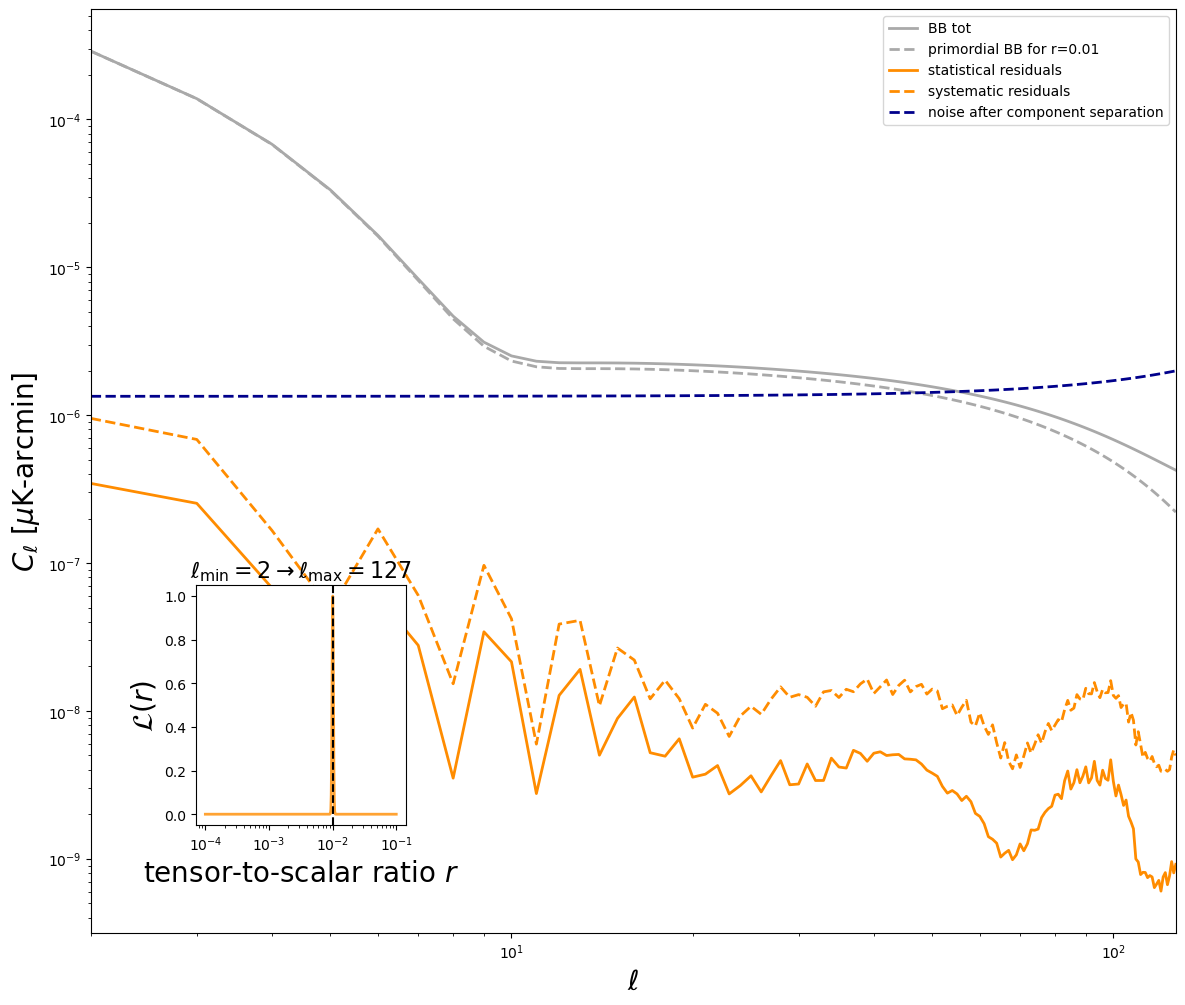

In [28]:
from fgbuster import xForecast, CMB, Dust, Synchrotron
res = xForecast(components, freq, full_array[:,:, :49152], 2, 2*nside-1, Alens=0.1, r=0.01, make_figure=True)